# Data Generated Analysis

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

GENERATED_ROOT_PATH = os.path.join("..", "input", "bugnet")
GENERATED_PAIRS_PATH = os.path.join(GENERATED_ROOT_PATH, "generated_pairs.csv")
CODEX_PAIRS_PATH = os.path.join(GENERATED_ROOT_PATH, "codex_results.csv")

In [2]:
df = pd.read_csv(GENERATED_PAIRS_PATH)

df.head()

,problem_id,language,original_status,original_src,changed_src,change,i1,i2,j1,j2,error
0,p00001,C++,Time Limit Exceeded,#include <stdio.h>\nint main(void) {\n int a ...,#include <stdio.h>\nint main(void) {\n int a ...,replace,3,4,3,4,TLE
1,p00001,C++,Runtime Error,#include <algorithm>\n#include <iostream>\nusi...,#include <algorithm>\n#include <iostream>\nusi...,replace,9,10,9,10,-11
2,p00001,C++,Runtime Error,#include <algorithm>\n#include <cstdio>\n\nusi...,#include <algorithm>\n#include <cstdio>\n\nusi...,replace,11,12,11,12,-11
3,p00001,C++,Time Limit Exceeded,#include <algorithm>\n#include <bitset>\n#incl...,#include <algorithm>\n#include <bitset>\n#incl...,replace,35,38,35,36,TLE
4,p00001,C++,Time Limit Exceeded,#include <iostream>\nusing namespace std;\n\ni...,#include <iostream>\nusing namespace std;\n\ni...,replace,19,20,19,20,TLE


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62030 entries, 0 to 62029
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   problem_id       62030 non-null  object
 1   language         62030 non-null  object
 2   original_status  62030 non-null  object
 3   original_src     62030 non-null  object
 4   changed_src      62030 non-null  object
 5   change           62030 non-null  object
 6   i1               62030 non-null  int64 
 7   i2               62030 non-null  int64 
 8   j1               62030 non-null  int64 
 9   j2               62030 non-null  int64 
 10  error            62030 non-null  object
dtypes: int64(4), object(7)
memory usage: 5.2+ MB


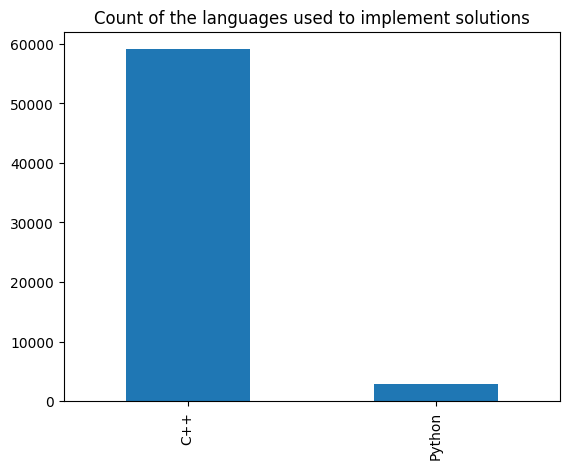

C++       59093
Python     2937
Name: language, dtype: int64

In [4]:
# there are a lot more C++ examples than Python examples
# - how to make the dataset more balanced?

value_counts = df["language"].value_counts()

value_counts.plot.bar()

plt.title("Count of the languages used to implement solutions")
plt.show()

value_counts

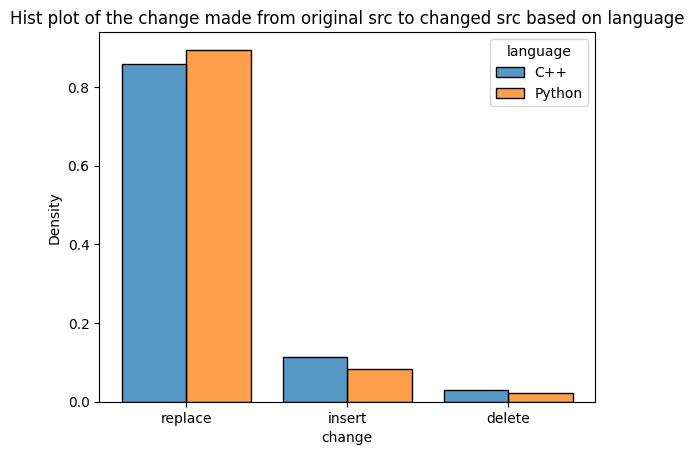

change
language change         
C++      delete     1692
         insert     6651
         replace   50750
Python   delete       64
         insert      245
         replace    2628

In [5]:
# the distribution of the changes made is similar between the two languages
# even though the number of examples is very different; the replace example
# is more interesting than the others; insert is also a bit interesting;
# delete is the least interesting because it doesn't require the model
# generate any code;

sns.histplot(x=df["change"], hue=df["language"], multiple="dodge", 
             stat="density", shrink=0.8, common_norm=False)

plt.title("Hist plot of the change made from original src to changed src based on language")
plt.show()

df.groupby(["language", "change"]).agg({"change": "count"})

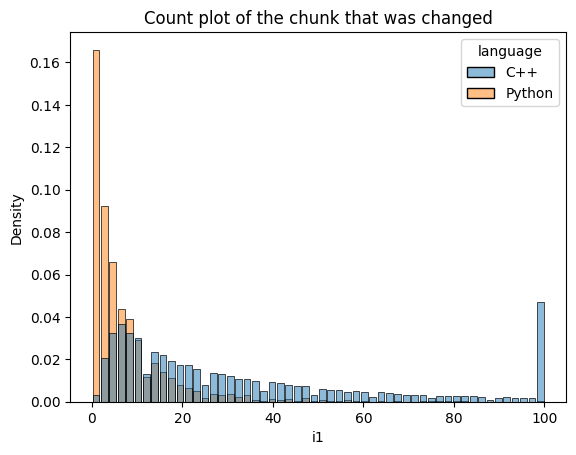

In [6]:
# most of the bugs happened in the beginning of the file; the plot
# displays the start line of the chunk that is buggy; it seems that
# for C++ there are some examples where the source code was very long;
# but for Python, most bugs occured on the first/second lines;

x = df["i1"].map(lambda line: line if line < 100 else 100)
sns.histplot(x=x, hue=df["language"], stat="density", shrink=0.8, common_norm=False)

plt.title("Count plot of the chunk that was changed")
plt.show()

The maximum size of a chunk is 170


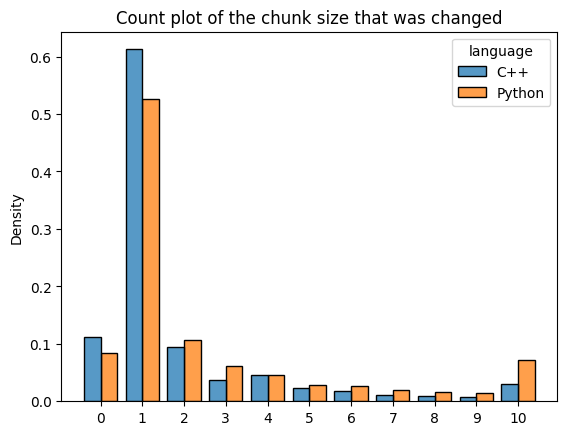

In [7]:
# the size of the chunks seems to be pretty constant; the most common
# size for a chunk is one; this means only one line change; this happens
# to be almost half of the samples; there are some zero lines changes,
# those are the insert changes; those require code to just be generated
# and do not require modifications, just insertion;

x = (df["i2"] - df["i1"])
x_cap = x.map(lambda line: line if line < 10 else 10).astype("category")

sns.histplot(x=x_cap, hue=df["language"], multiple="dodge", 
             stat="density", shrink=0.8, common_norm=False)
plt.xticks(list(range(11)))

print(f"The maximum size of a chunk is {x.max()}")

plt.title("Count plot of the chunk size that was changed")
plt.show()

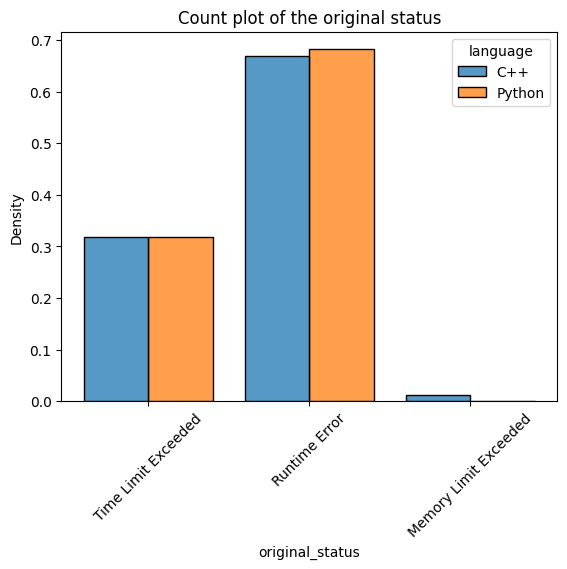

original_status
language original_status                       
C++      Memory Limit Exceeded              744
         Runtime Error                    39512
         Time Limit Exceeded              18837
Python   Memory Limit Exceeded                1
         Runtime Error                     2003
         Time Limit Exceeded                933

In [8]:
# the type of error from the original dataset (original status);
# very few examples with MLE, but there are a decent amount of TLE bugs;
# most of the bugs are Runtime Errors;

sns.histplot(x=df["original_status"], hue=df["language"], multiple="dodge", 
             stat="density", shrink=0.8, common_norm=False)

plt.title("Count plot of the original status")
plt.xticks(rotation=45)
plt.show()

df.groupby(["language", "original_status"]).agg({"original_status": "count"})

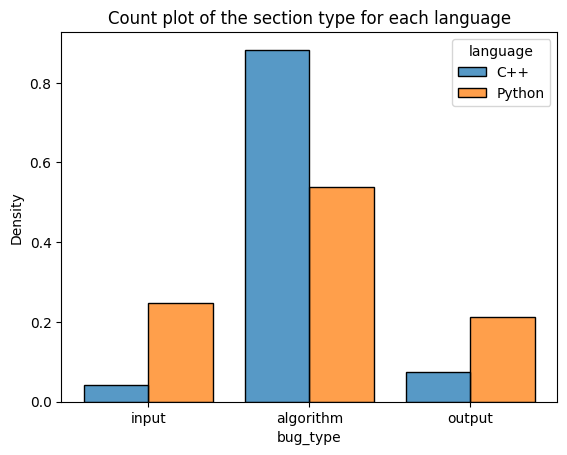

In [9]:
# very simple way of deciding if the bug is related to input is to check if
# the usual functions for reading for each language are in the changed
# source code (accepted); we can do the same for output; and we can consider
# the rest as algorithm; pretty dumb, but it can work at some extent; maybe
# try to do this better?
# obviously most of the bugs are in the algorithm category; for Python there
# are also a lot of input examples (and also output); C++ has a lot more
# examples in the algorithm category than Python;

def get_bug_type(row: pd.Series) -> str:
    line = "\n".join(row["changed_src"].splitlines()[row["j1"]:row["j2"]])
    language = row["language"]

    if language == "Python":
        return (
            "input"
            if "input" in line
            else "output"
            if "print" in line
            else "algorithm"
        )

    if language == "C++":
        return (
            "input"
            if ("cin" in line or "scanf" in line)
            else "output"
            if ("cout" in line or "printf" in line)
            else "algorithm"
        )

    raise NotImplementedError(f"{language} not implemented yet")

df["bug_type"] = df.apply(get_bug_type, axis="columns")

sns.histplot(x=df["bug_type"], hue=df["language"], multiple="dodge", 
             stat="density", shrink=0.8, common_norm=False)

plt.title("Count plot of the section type for each language")
plt.show()

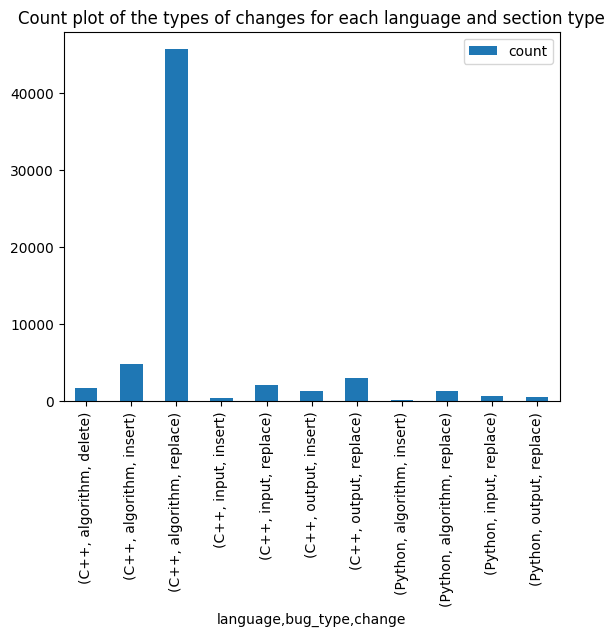

count
language bug_type  change        
C++      algorithm delete    1692
                   insert    4852
                   replace  45653
         input     insert     409
                   replace   2113
         output    insert    1390
                   replace   2984
Python   algorithm insert     180
                   replace   1337
         input     replace    711
         output    replace    580

In [10]:
# most of the algorithm changes are replace modifications; there are some
# deletes for C++ (only C++ algorithm); Python has mostly replace changes;

agg_df = df.groupby(["language", "bug_type", "change"]).agg({"change": "count"})
agg_df = agg_df[agg_df["change"] > 100]
agg_df.columns = ["count"]

agg_df.plot.bar()

plt.title("Count plot of the types of changes for each language and section type")
plt.show()

agg_df

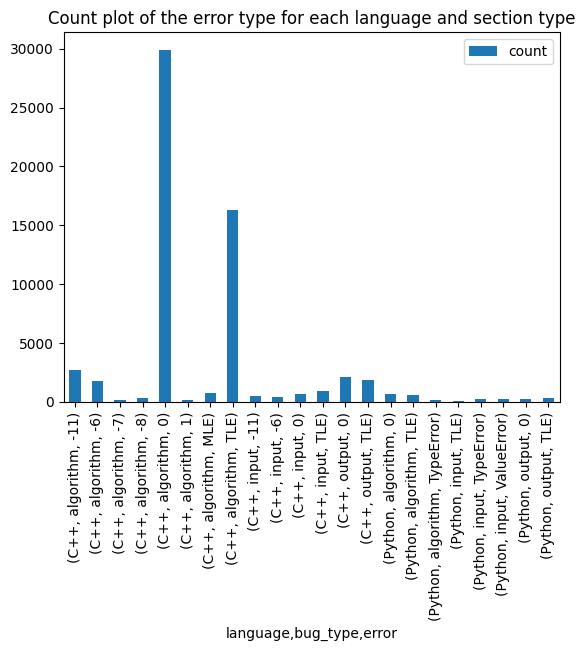

count
language bug_type  error            
C++      algorithm -11          2663
                   -6           1784
                   -7            154
                   -8            359
                   0           29914
                   1             133
                   MLE           724
                   TLE         16332
         input     -11           460
                   -6            374
                   0             702
                   TLE           914
         output    0            2088
                   TLE          1858
Python   algorithm 0             655
                   TLE           574
                   TypeError     158
         input     TLE           102
                   TypeError     205
                   ValueError    231
         output    0             214
                   TLE           299

In [11]:
# there are some 0 return code examples, but it is what it is, we don't have
# all test cases; for C++ most algorithm bugs happen because of TLE and there
# are also some that fail because of segfault (-11); for C++ input, it is 
# very similar, with more TLE and some segfaults, but this time the count 
# is more balanced; for C++ output most bugs happen because of TLE; it looks like
# the most bugs for C++ happen because of TLE; the ones that resulted in Runtime
# Error (which previously we seen that is the majoritary class) have a return code
# of 0 (maybe missing test cases); Python is similar, it has mostly TLE bugs; but
# for reading input it has some TypeError and ValueError (maybe converting gone wrong)

agg_df = df.groupby(["language", "bug_type", "error"]).agg({"change": "count"})
agg_df = agg_df[agg_df["change"] > 100]
agg_df.columns = ["count"]

agg_df.plot.bar()

plt.title("Count plot of the error type for each language and section type")
plt.show()

agg_df

In [12]:
# correlation between the bug type and error type;
# idk what this shows, seems like there is not that much correlation;
# between the error type and the bug section type;
# there is more correlation between the error type and the original status
# which makes sense I guess;

df["bug_type_cat"]=df["bug_type"].astype("category").cat.codes
df["error_cat"]=df["error"].astype("category").cat.codes
df["original_status_cat"]=df["original_status"].astype("category").cat.codes

corr = df.groupby("language")[["bug_type_cat", "error_cat", "original_status_cat"]].corr()

print("Correlation of error and bug type")
corr.style.background_gradient(cmap='coolwarm')

Correlation of error and bug type
